# Draft of classification module

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import scipy.io as sio
import os
import ieeg_funcs as ief
import dgFuncs as dg
from sklearn import svm
from sklearn.externals import joblib

In [43]:
# Block for re-loading my libraries if I make updates
import imp 
imp.reload(ief) 
imp.reload(dg) 

<module 'dgFuncs' from '/Users/davidgroppe/PycharmProjects/DG_LIBRARY/dgFuncs.py'>

In [2]:
# Import list of subjects to use
path_dict=ief.get_path_dict()
use_subs_df=pd.read_csv(os.path.join(path_dict['szr_ant_root'],'use_subs.txt'),header=None,na_filter=False)
test_sub_list=['NA']
train_subs_list=[]
for sub in use_subs_df.iloc[:,0]:
    if not sub in test_sub_list:
        train_subs_list.append(sub)
        
print('Training subs: {}'.format(train_subs_list))

Training subs: ['CC', 'CJ', 'CO', 'CT', 'IB', 'JW', 'RB', 'TF']


In [3]:
# Figure out how much data there is to preallocate mem
n_ftrs=0
n_wind=0
for sub in train_subs_list:
    ftr_path=os.path.join(path_dict['ftrs_root'],'PWR',sub)
    for f in os.listdir(ftr_path):
        ftr_dict=np.load(os.path.join(ftr_path,f))
        if n_ftrs==0:
            n_ftrs=ftr_dict['db_pwr'].shape[0]
        n_wind+=np.sum(ftr_dict['peri_ictal']>=0)
print('n_ftrs=%d' % n_ftrs)
print('n_wind=%d' % n_wind)

n_ftrs=6
n_wind=95615


In [4]:
ftr_dict.keys()

['time_wind_sec', 'db_pwr', 'peri_ictal']

In [5]:
# Load all data into a giant matrix
ftrs=np.zeros((n_wind,n_ftrs))
szr_class=np.zeros(n_wind)
sub_id=np.zeros(n_wind)
wind_ct=0
sub_ct=0
for sub in train_subs_list:
    ftr_path=os.path.join(path_dict['ftrs_root'],'PWR',sub)
    for f in os.listdir(ftr_path):
        ftr_dict=np.load(os.path.join(ftr_path,f))
        neo_wind=np.sum(ftr_dict['peri_ictal']>=0)
        ftrs[wind_ct:wind_ct+neo_wind,:]=ftr_dict['db_pwr'][:,:neo_wind].T
        szr_class[wind_ct:wind_ct+neo_wind]=ftr_dict['peri_ictal'][:neo_wind]
        sub_id[wind_ct:wind_ct+neo_wind]=np.ones(neo_wind)*sub_ct
        wind_ct+=neo_wind
    sub_ct+=1

In [6]:
print(szr_class.shape)
print(ftrs.shape)

(95615,)
(95615, 6)


In [7]:
bro=szr_class[sub_id!=0]
bro.shape

(90170,)

In [ ]:
# need to scale data
#class_weight='balanced' and/o

#gamma defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected.
# Proper choice of C and gamma is critical to the SVM’s performance. One is advised to 
# use sklearn.model_selection.GridSearchCV with C and gamma spaced exponentially far apart 
# to choose good values.

In [8]:
# LOOCV on training data
left_out_id=0
C = 1.0  # SVM regularization parameter, the smaller it is, the stronger the regularization
#rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(ftrs.T, szr_class)
rbf_svc = svm.SVC(class_weight='balanced')
# rbf_svc.fit? # could add sample weight to weight each subject equally
rbf_svc.fit(ftrs[sub_id!=left_out_id,:], szr_class[sub_id!=left_out_id])
#clf = svm.SVC()
# >>> clf.fit(X, y)  


SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [52]:
train_bool=sub_id!=left_out_id
valid_bool=sub_id==left_out_id

In [63]:
#training_class_hat=rbf_svc.predict(ftrs)
# training_class_hat=rbf_svc.predict(ftrs[sub_id!=left_out_id,:])
training_class_hat=rbf_svc.predict(ftrs)

In [14]:
ftrs.shape

(95615, 6)

In [64]:
train_bool=sub_id!=left_out_id
valid_bool=sub_id==left_out_id
ictal_bool=szr_class==1
preictal_bool=szr_class==0
jive=training_class_hat==szr_class

In [68]:
# Training Data Results
train_acc=np.mean(jive[train_bool])
print('Training accuracy: %f' % train_acc)
use_ids=np.multiply(train_bool,ictal_bool)
train_sens=np.mean(jive[use_ids])
print('Training sensitivity: %f' % train_sens)
use_ids=np.multiply(train_bool,preictal_bool)
train_spec=np.mean(jive[use_ids])
print('Training specificity: %f' % train_spec)

Training accuracy: 0.975491
Training sensitivity: 0.974138
Training specificity: 0.975614


In [69]:
# Validation Data Results
valid_acc=np.mean(jive[valid_bool])
print('Validation accuracy: %f' % valid_acc)
use_ids=np.multiply(valid_bool,ictal_bool)
valid_sens=np.mean(jive[use_ids])
print('Validation sensitivity: %f' % valid_sens)
use_ids=np.multiply(valid_bool,preictal_bool)
valid_spec=np.mean(jive[use_ids])
print('Validation specificity: %f' % valid_spec)

Validation accuracy: 0.882645
Validation sensitivity: 0.017949
Validation specificity: 0.949357


In [57]:
train_acc=np.mean(training_class_hat==szr_class[train_bool])
perionset_bool=szr_class==1
use_ids=np.multiply(perionset_bool,train_bool)
train_sens=np.mean(training_class_hat[np.multiply(perionset_bool,train_bool)]==szr_class[train_bool])
print('Training accuracy: %f' % train_acc) #0.975892903833 acc all training

Training accuracy: 0.975491


In [59]:
temp_fname='CC_d6_sz1_bppwr.npz'
stem=temp_fname.split('_bppwr.npz')[0]
print(stem)

CC_d6_sz1


In [10]:
# Load validation data and calculate false positive rate, and peri-onset latency
sub=train_subs_list[left_out_id]
ftr_path=os.path.join(path_dict['ftrs_root'],'PWR',sub)
for f in os.listdir(ftr_path):
    print('Loading file %s' % f)
    ftr_dict=np.load(os.path.join(ftr_path,f))

Loading file CC_d6_sz1_bppwr.npz
Loading file CC_d7_sz1_bppwr.npz
Loading file CC_d9_sz1_bppwr.npz


In [60]:
temp_dict=np.load('/Users/davidgroppe/PycharmProjects/SZR_ANT/FTRS/VLTG/NA/NA_d1_sz2_vltg.npz')

In [61]:
temp_dict.keys()

['peri_ictal', 'vltg_ftrs', 'time_wind_sec', 'ftr_list']

In [62]:
temp_dict['vltg_ftrs'].shape

(5, 1860)

In [11]:
ftr_dict.keys()

['time_wind_sec', 'db_pwr', 'peri_ictal']

In [13]:
ftr_dict['db_pwr'].shape

(6, 2170)

In [15]:
szr_class_hat=rbf_svc.predict(ftr_dict['db_pwr'].T)

In [ ]:
# Earliest hit
szr_class_hat

In [36]:
blah= np.where(szr_class_hat==2)

In [38]:
len(blah[0])

0

In [63]:
txt_fname='/Users/davidgroppe/Downloads/EpilepsyCenters.html'
stuff = open(txt_fname).read()

In [69]:
import re
dir_ids=[m.start() for m in re.finditer('Med Dir:', stuff)]
print(len(dir_ids))

389


In [41]:
# itemindex = numpy.where(array==item)
pos_ids = np.where(szr_class_hat==1)
ictal_ids = np.where(ftr_dict['peri_ictal']==1)
missed_szr_ct=0
if len(pos_ids[0])>0:
    onset_dif_sec=(pos_ids[0][0]-ictal_ids[0][0])/10
else:
    missed_szr_ct+=1
print(onset_dif_sec)

-179.7


In [70]:
import imp 
imp.reload(ief) 
# imp.reload(dg) 
onset_dif_sec=ief.cmpt_stim_latency(szr_class_hat,ftr_dict['peri_ictal'],1/10)
print(onset_dif_sec)

-179.7


In [75]:
import imp 
imp.reload(ief) 
# imp.reload(dg) 
onset_dif_sec=ief.cmpt_postonset_stim_latency(szr_class_hat,ftr_dict['peri_ictal'],1/10)
print(onset_dif_sec)

2.0


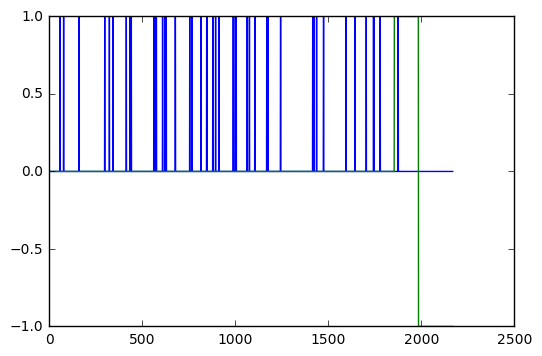

In [76]:
_=plt.plot(szr_class_hat,label='class hat')
_=plt.plot(ftr_dict['peri_ictal'],label='class')

In [54]:
# Find clusters of contiguous ictal predictions
clust_mass_list=list()
clust_class_list=list()

in_clust=0
clust_class=0
for ct, a in enumerate(szr_class_hat):
    if a==1 and in_clust>0:
        # increment cluster size
        in_clust+=1
    elif a==1 and in_clust==0:
        # increment cluster size
        in_clust+=1
        clust_class=ftr_dict['peri_ictal'][ct]
    elif a==0 and in_clust>0:
        # end of cluster
        clust_mass_list.append(in_clust)
        clust_class_list.append(clust_class)
        in_clust=0
        
if a==1 and in_clust>0:
    # end of time series forces end of cluster
    clust_mass_list.append(in_clust)
    clust_class_list.append(clust_class)

clust_mass=np.asarray(clust_mass_list)
clust_class=np.asarray(clust_class_list)
print(clust_mass)
print(clust_class)
# pre_clusters=np.asarray(preictal_clust_list)
# ictal_clusters=np.asarray(ictal_clust_list)
# # print(preictal_clust)
# print(pre_clusters)
# print(ictal_clusters)
    

[1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 2 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1
 2 1 1 1 1 2 1 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1]


In [55]:
from sklearn import metrics
#fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=1)
fpr, tpr, thresholds = metrics.roc_curve(clust_class, clust_mass, pos_label=1)
auc=metrics.auc(fpr, tpr)
print(auc)

0.909090909091


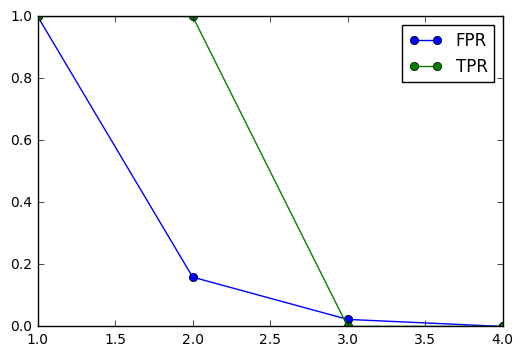

In [58]:
_=plt.plot(thresholds,fpr,'-o',label='FPR')
_=plt.plot(thresholds,tpr,'-o',label='TPR')
_=plt.legend()

In [45]:
import tensorflow as tf
import keras

ImportError: No module named 'keras'

In [20]:
itemindex[:4]

(array([  58,   77,  160,  298,  323,  342,  414,  434,  441,  562,  567,
         572,  575,  576,  609,  621,  622,  629,  677,  678,  755,  767,
         815,  846,  847,  848,  879,  894,  913,  989, 1000, 1005, 1064,
        1076, 1105, 1169, 1174, 1176, 1243, 1244, 1416, 1422, 1437, 1474,
        1475, 1595, 1644, 1704, 1743, 1745, 1746, 1779, 1875, 1876]),)

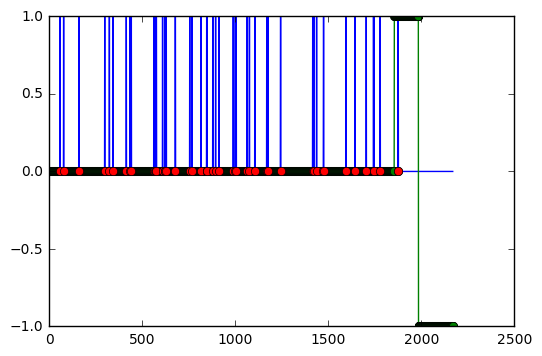

In [21]:
_=plt.plot(szr_class_hat)
_=plt.plot(ftr_dict['peri_ictal'],'-o')
_=plt.plot(itemindex,np.zeros(len(itemindex)),'ro')

In [ ]:
ftrs=np.zeros((n_wind,n_ftrs))
szr_class=np.zeros(n_wind)
sub_id=np.zeros(n_wind)
wind_ct=0
sub_ct=0
for sub in train_subs_list:
    ftr_path=os.path.join(path_dict['ftrs_root'],'PWR',sub)
    for f in os.listdir(ftr_path):
        ftr_dict=np.load(os.path.join(ftr_path,f))
        neo_wind=np.sum(ftr_dict['peri_ictal']>=0)
        ftrs[wind_ct:wind_ct+neo_wind,:]=ftr_dict['db_pwr'][:,:neo_wind].T
        szr_class[wind_ct:wind_ct+neo_wind]=ftr_dict['peri_ictal'][:neo_wind]
        sub_id[wind_ct:wind_ct+neo_wind]=np.ones(neo_wind)*sub_ct
        wind_ct+=neo_wind
    sub_ct+=1

In [ ]:
# clf = svm.SVC()
# >>> clf.fit(X, y)  
# SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
#     decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
#     max_iter=-1, probability=False, random_state=None, shrinking=True,
#     tol=0.001, verbose=False)
# >>> clf.predict([[2., 2.]])
# array([1])

In [72]:
np.savez('classification_metrics.npz',
         valid_sens=valid_sens,
         valid_spec=valid_spec,
         train_sens=train_sens,
         train_spec=train_spec,
         train_subs_list=train_subs_list,
         left_out_id=left_out_id)